# Findings 

#### Decision Tree Classifier 
- Used GridSearchCV to find best max depth param of 9
- 0.97 score for both Precision and Recall on 'successful' projects 
- 0.81 weight avg. F-1 score
- checked for overfitting, concluded model was not overfit. 
- feature importance found that backers, usd_pledged, and goal were major determining factors
- addressed imbalanced data with SMOTE, 0.86 weighted avg. recall score
- 0.98 weighted avg. for binary classification using decision tree

#### Random Forest Classifier
- 0.96 and 0.96 Precision and Recall score on 'successful' projects
- 0.87 weighted avg. recall score
- feature importance for model is same three, backers, usd_pledged, and goal
- 0.98 weighted precision and recall score for binary classification 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv('EDA_Data.csv', index_col = 0)

In [3]:
df.head()

,main_category,currency,goal,state,backers,country,usd_pledged,total_days
0,Publishing,GBP,1000.0,failed,0,GB,0.0,58.0
1,Film & Video,USD,45000.0,failed,3,US,220.0,45.0
2,Music,USD,5000.0,failed,1,US,1.0,30.0
3,Film & Video,USD,19500.0,canceled,14,US,1283.0,55.0
4,Food,USD,50000.0,successful,224,US,52375.0,35.0


In [4]:
df.dtypes

main_category     object
currency          object
goal             float64
state             object
backers            int64
country           object
usd_pledged      float64
total_days       float64
dtype: object

# Data Preprocessing

In [5]:
#separating the categorical/object data types

dfo = df[['main_category', 'currency', 'country']]

In [6]:
#getting dummies for categoritcal values and adding to the main dataframe while deleting the original features

df = pd.concat([df.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1)

In [7]:
#creating X and y values, since we are trying to predict the state of the project, this will be our y

X = df.drop('state', axis = 1)
y = df['state']

In [8]:
#splitting the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# DecisionTreeClassifier

In [9]:
#finding the best max_depth parameter through gridsearch

decision_tree = DecisionTreeClassifier()
grid_param = {'max_depth': np.arange(3,10),}
#can try to add max_samples_split or max_samples_leaf but it might be computationally expensive and take a lot of time. 

tree_gridsearchcv = GridSearchCV(decision_tree, grid_param)

tree_gridsearchcv.fit(X_train, y_train)
tree_gridsearchcv.best_params_

{'max_depth': 9}

In [10]:
#retraining decision tree model based off of best max_depth param of 9

decision_tree = DecisionTreeClassifier(max_depth = 9)
decision_tree = decision_tree.fit(X_train, y_train)
tree_y_pred = decision_tree.predict(X_test)


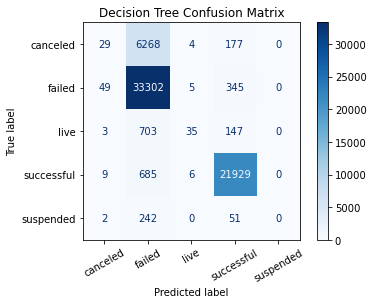

In [11]:
from sklearn import metrics

metrics.plot_confusion_matrix(decision_tree, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')
plt.xticks(rotation=30)
plt.show()

The confusion matrix shows that our model was pretty great at predicting which projects failed, did decently to predict which projects were successful, but everything lese, the model did a poor job of predicting correctly. For the most part, this isn't too bad, but for example, the 685 that were true successfuls, but our tree model predicted that it failed, that is an area we might be able tune a bit more for better results. 

In [12]:
print(metrics.classification_report(y_test, tree_y_pred))

#would focus on weighted average as the metric of choice

C:\Users\blee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    canceled       0.32      0.00      0.01      6478
      failed       0.81      0.99      0.89     33701
        live       0.70      0.04      0.07       888
  successful       0.97      0.97      0.97     22629
   suspended       0.00      0.00      0.00       295

    accuracy                           0.86     63991
   macro avg       0.56      0.40      0.39     63991
weighted avg       0.81      0.86      0.81     63991



# Check for overfitting

Pot report for training set to see if there is overfitting, results usually should be exaclty the same if not overfit, 
but if there are more than 5pts difference, then it is overfitting

In [13]:
y_train_pred = decision_tree.predict(X_train)

In [14]:
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

    canceled       0.65      0.01      0.02     25914
      failed       0.81      0.99      0.89    134802
        live       0.87      0.05      0.10      3550
  successful       0.97      0.97      0.97     90514
   suspended       1.00      0.01      0.01      1182

    accuracy                           0.87    255962
   macro avg       0.86      0.41      0.40    255962
weighted avg       0.85      0.87      0.82    255962



don't believe there is overfitting, because the weighted average for both the test and training 
sets are very similar, around 0.86. The scores for failed and successful categories also recieved 
identical scores. 

# Feature Importance for Decision Tree 

<BarContainer object of 53 artists>

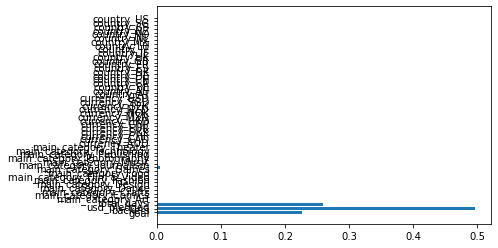

In [15]:
importances = decision_tree.feature_importances_
plt.barh(X_test.columns, importances)

#this is really hard to see with all the different features, but it looks like there are really only 3 that made a difference

let's separate the top 3 and plot those in terms of feature importance 

Text(0.5, 1.0, 'Feature Importance for Decision Tree Model')

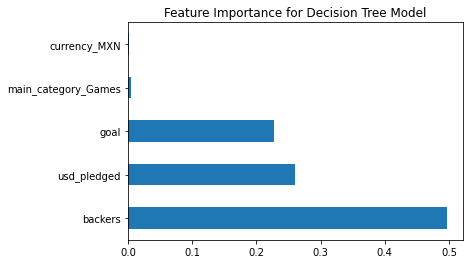

In [16]:
importances = pd.Series(importances, index=X_test.columns)
importances.nlargest(5).plot(kind = 'barh')
plt.title('Feature Importance for Decision Tree Model')

very clear here that the number of backers, usd_pledged amount, and the goal amount are the influencers of the model. 
our initial hypothesis that the main category, or even total days of project might have influence is proved false. 

# Adjusting model to unbalanced data 


number of samples per class is not balanced, let's do something to balance it out
imblearn from sklearn for data imbalances

In [17]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_os, y_os = sm.fit_resample(X, y)

In [18]:
X_train_os, X_test_os, y_train_os, y_test_os = train_test_split(X_os, y_os, test_size = 0.2, random_state = 42)

In [19]:
#refitting classifier with oversample data 
decision_tree.fit(X_train_os, y_train_os)
y_pred_os = decision_tree.predict(X_test_os)

In [20]:
print(metrics.classification_report(y_test_os, y_pred_os))

              precision    recall  f1-score   support

    canceled       0.39      0.37      0.38     33640
      failed       0.52      0.71      0.60     33582
        live       0.64      0.48      0.55     33794
  successful       0.85      0.90      0.88     33680
   suspended       0.55      0.49      0.52     33807

    accuracy                           0.59    168503
   macro avg       0.59      0.59      0.59    168503
weighted avg       0.59      0.59      0.59    168503



In [21]:
import imblearn
print(imblearn.metrics.classification_report_imbalanced(y_test, tree_y_pred))

C:\Users\blee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

   canceled       0.32      0.00      1.00      0.01      0.07      0.00      6478
     failed       0.81      0.99      0.74      0.89      0.85      0.75     33701
       live       0.70      0.04      1.00      0.07      0.20      0.04       888
 successful       0.97      0.97      0.98      0.97      0.98      0.95     22629
  suspended       0.00      0.00      1.00      0.00      0.00      0.00       295

avg / total       0.81      0.86      0.86      0.81      0.80      0.73     63991



# Binary classification for Decision Tree

In [22]:
from sklearn import preprocessing 
y2 = preprocessing.label_binarize(y, classes = ['successful'])

In [23]:
#retraining classifier since the y is now binary class
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size = 0.2, random_state = 42)
decision_tree = decision_tree.fit(X_train2, y_train2)
tree_y_pred2 = decision_tree.predict(X_test2)

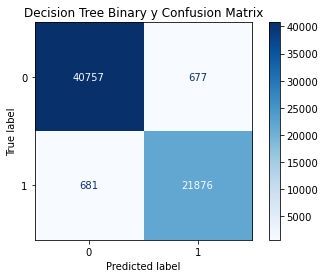

In [24]:
metrics.plot_confusion_matrix(decision_tree, X_test2, y_test2, cmap=plt.cm.Blues)
plt.title('Decision Tree Binary y Confusion Matrix')
plt.show()

In [25]:
print(metrics.classification_report(y_test2, tree_y_pred2))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     41434
           1       0.97      0.97      0.97     22557

    accuracy                           0.98     63991
   macro avg       0.98      0.98      0.98     63991
weighted avg       0.98      0.98      0.98     63991



If we compare the results of multicalss vs binary for the target variable, the 'successful' score is about the same at .97 for both precision and recall, but by creating a binary target variable, the precision and recall for nonpositive or 'failed/canceled, etc.' labels score is higher in precision. 

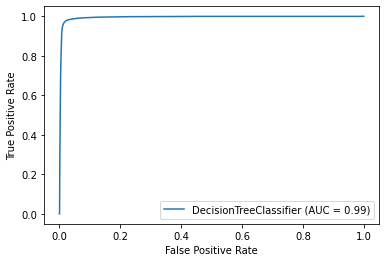

In [26]:
metrics.plot_roc_curve(decision_tree, X_test2, y_test2)
plt.show()

In [27]:
auc = metrics.roc_auc_score(y_test2, decision_tree.predict_proba(X_test2)[:,1])
print("AUC:",auc)

AUC: 0.9942303935028234


# RandomForestClassifier 


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
forest = RandomForestClassifier()
#better to keep max depth flexible, and then gridsearch for n_estimators 

In [29]:
param_grid = {'n_estimators': [50, 100]}
forest_randomsearchcv = RandomizedSearchCV(forest, param_grid)
forest_randomsearchcv.fit(X_train, y_train)
forest_randomsearchcv.best_params_

C:\Users\blee\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 100}

In [30]:
forest = RandomForestClassifier(n_estimators = 100)

In [31]:
forest.fit(X_train, y_train)
forest_y_pred = forest.predict(X_test)

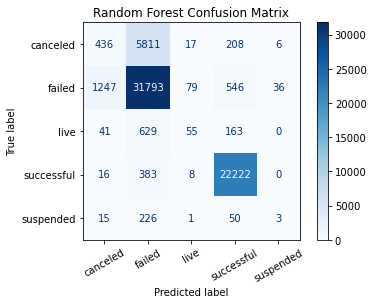

In [32]:
metrics.plot_confusion_matrix(forest, X_test, y_test, cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.xticks(rotation=30)
plt.show()

In [33]:
print(metrics.classification_report(y_test, forest_y_pred))

              precision    recall  f1-score   support

    canceled       0.25      0.07      0.11      6478
      failed       0.82      0.94      0.88     33701
        live       0.34      0.06      0.10       888
  successful       0.96      0.98      0.97     22629
   suspended       0.07      0.01      0.02       295

    accuracy                           0.85     63991
   macro avg       0.49      0.41      0.42     63991
weighted avg       0.80      0.85      0.82     63991



# Balanced Random Forest Classifier

In [34]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators = 100)
brf.fit(X_train, y_train)
brf_y_pred = brf.predict(X_test)

In [35]:
print(metrics.classification_report(y_test, brf_y_pred))

              precision    recall  f1-score   support

    canceled       0.22      0.33      0.27      6478
      failed       0.88      0.43      0.58     33701
        live       0.08      0.54      0.14       888
  successful       0.91      0.90      0.91     22629
   suspended       0.01      0.48      0.03       295

    accuracy                           0.59     63991
   macro avg       0.42      0.54      0.39     63991
weighted avg       0.81      0.59      0.66     63991



Text(0.5, 1.0, 'Feature Importance for Random Forest')

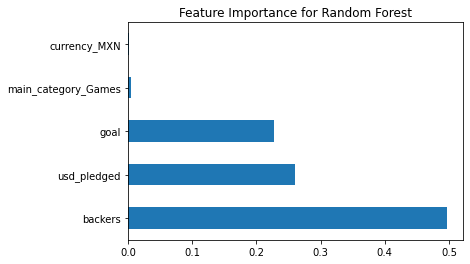

In [36]:
importances2 = forest.feature_importances_
importances2 = pd.Series(importances, index=X_test.columns)
importances2.nlargest(5).plot(kind = 'barh')
plt.title('Feature Importance for Random Forest')

#it looks like the same three features are listed in the Random Forest model

# Binary Classificaiton for Random Forest 

In [37]:
forest.fit(X_train2, y_train2)
forest_y_pred2 = forest.predict(X_test2)

<ipython-input-37-d391109edb05>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train2, y_train2)


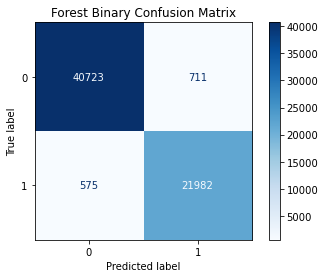

In [38]:
metrics.plot_confusion_matrix(forest, X_test2, y_test2, cmap=plt.cm.Blues)
plt.title('Forest Binary Confusion Matrix')
plt.show()

In [39]:
print(metrics.classification_report(y_test2, forest_y_pred2))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     41434
           1       0.97      0.97      0.97     22557

    accuracy                           0.98     63991
   macro avg       0.98      0.98      0.98     63991
weighted avg       0.98      0.98      0.98     63991



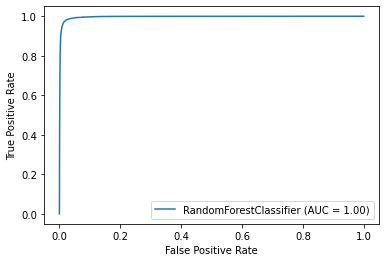

In [40]:
metrics.plot_roc_curve(forest, X_test2, y_test2)
plt.show()

In [41]:
auc = metrics.roc_auc_score(y_test2, forest.predict_proba(X_test2)[:,1])
print("AUC:",auc)

AUC: 0.996938722290224
